In [44]:
#https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Running-VQE-on-the-statevector-Simulator

# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [106]:
import pandas as pd
import numpy as np
from zipfile import *
import warnings, os, gzip
warnings.filterwarnings('ignore')
pth = os.getcwd() + r'/quantistry'

def get_coord(zip_file):
    all_res = []

    with ZipFile(zip_file, 'r') as f:
        coord_list = [x for x in f.namelist() if 'csv' not in x]
        for i in coord_list:
            tmp = f.extract(i)
            df = pd.read_csv(tmp)

            new_df = []
            for j in range(len(df)):
                df.iloc[j] = df.iloc[j].str.replace('  ', ' ', regex = True)
                new_df.append(df.iloc[j].str.split(' ', expand = True))

            new_df = pd.concat(new_df)
            
            new_df0 = pd.DataFrame(['{}'.format(i).replace('.xyz', '')] * len(new_df), columns = ['step'])
            
            new_df1 = new_df.iloc[:, 0].reset_index(drop = True)
            
            new_df2 = new_df.iloc[:, 1:]
            out = pd.DataFrame(new_df2.iloc[:,::-1].apply(lambda x: x.dropna().tolist(), axis=1).tolist(), columns=new_df2.columns[::-1]).iloc[:,::-1]
            out.replace('', float('NaN'), inplace = True)
            out.dropna(axis = 1, how = 'all', inplace = True)

            final = pd.concat([new_df0, new_df1, out], axis = 1)
            final.columns = ['step', 'atom', 'x', 'y', 'z']
            all_res.append(final)

        f.close()
        
    return pd.concat(all_res)

Co2_CO2 = get_coord(pth + r'/Co2_CO2.zip')


        step atom                   x                  y                  z
0   step_000   Co   6.844708500129254  5.772690500054138  5.000000000000000
1   step_000    O   8.228239500226193  6.352208500094744  5.000000000000000
2   step_000    C   9.292723500300781  6.822059500127666  5.000000000000000
3   step_000    O  10.323201500372985  7.276646500159519  5.000000000000000
0   step_001   Co   6.764503782732331  5.739095260921351  5.000000000000000
..       ...  ...                 ...                ...                ...
3   step_022    O  12.087705283105313  8.015741761080868  5.000000000000000
0   step_023   Co   5.000000000000000  5.000000000000000  5.000000000000000
1   step_023    O  10.072948000355447  7.124899000148885  5.000000000000000
2   step_023    C  11.137432000430033  7.594750000181807  5.000000000000000
3   step_023    O  12.167910000502239  8.049337000213658  5.000000000000000

[96 rows x 5 columns]


In [142]:
def getCoordinate(data):
    mol = data.get("atom").values[:4]
    coordx = float(data.get("x")[:1].values[:1].real[0])
    coordy = float(data.get("y")[:1].values[:1].real[0])
    coordz = float(data.get("z")[:1].values[:1].real[0])

    print(data, dir(mol), mol)
    print(dir(coordx), coordx)
    coord = [coordx,coordy,coordz]
    return mol, coord
mol, coord = getCoordinate(Co2_CO2)
print(mol, coord)



        step atom                   x                  y                  z
0   step_000   Co   6.844708500129254  5.772690500054138  5.000000000000000
1   step_000    O   8.228239500226193  6.352208500094744  5.000000000000000
2   step_000    C   9.292723500300781  6.822059500127666  5.000000000000000
3   step_000    O  10.323201500372985  7.276646500159519  5.000000000000000
0   step_001   Co   6.764503782732331  5.739095260921351  5.000000000000000
..       ...  ...                 ...                ...                ...
3   step_022    O  12.087705283105313  8.015741761080868  5.000000000000000
0   step_023   Co   5.000000000000000  5.000000000000000  5.000000000000000
1   step_023    O  10.072948000355447  7.124899000148885  5.000000000000000
2   step_023    C  11.137432000430033  7.594750000181807  5.000000000000000
3   step_023    O  12.167910000502239  8.049337000213658  5.000000000000000

[96 rows x 5 columns] ['T', '__abs__', '__add__', '__and__', '__array__', '__array_fina

In [152]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
["Co",[6.844708500129254,      5.772690500054138,      5.000000000000000]],
["O",[8.228239500226193,      6.352208500094744,      5.000000000000000]],
["C",[9.292723500300781,      6.822059500127666,      5.000000000000000]],
["O",[10.323201500372985,      7.276646500159519,      5.000000000000000]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )
    
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    print("Debug data: ")
    print(dir(properties), properties._properties, properties.molecule)
    
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    print(num_particles)
    print(num_spin_orbitals)

    print("Freezing CORE Orbitals")
    fc_transformer = FreezeCoreTransformer()

    fc_problem = fc_transformer.transform(properties)
    num_particles = (fc_problem
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(fc_problem
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    print(num_particles)
    print(num_spin_orbitals)
    print(dir(properties), properties._properties, properties.molecule)
    #    print(fc_problem.hamiltonian.constants)

    print("Freezing Custom Orbitals")
    fc_transformer = FreezeCoreTransformer(remove_orbitals=range(13,33))

    fc_problem = fc_transformer.transform(properties)
    num_particles = (fc_problem
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(fc_problem
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    print(num_particles)
    print(num_spin_orbitals)
    #print(fc_problem.hamiltonian.constants)

    print("Active space transformer")
    as_transformer = ActiveSpaceTransformer(6, 6)
    as_problem = as_transformer.transform(properties)
    num_particles = (fc_problem
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(fc_problem
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    print(num_particles)
    print(num_spin_orbitals)
    #print(as_problem.hamiltonian.electronic_integrals.alpha)

    print("Active space transformer SET Active orbitals")
    as_transformer = ActiveSpaceTransformer(6, 6)#, active_orbitals=[30, 33])
    as_problem = as_transformer.transform(properties)
    num_particles = (fc_problem
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(fc_problem
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    print(num_particles)
    print(num_spin_orbitals)
    #print(as_problem.hamiltonian.electronic_integrals.alpha)

    #stop;
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=range(13,30) # 13,33
                              ),
         #ActiveSpaceTransformer(6, 6)#, active_orbitals=[30,33])
        ])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
         

    mapper = ParityMapper()  # Set Mapper
    print(second_q_ops)
    hamiltonian = second_q_ops['ElectronicEnergy']  # Set Hamiltonian
    
    print(dir(hamiltonian))
    print(hamiltonian.terms)
    #print(problem.hamiltonian.electronic_integrals.alpha)

    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    print("Before reduction ", hamiltonian, qubit_op)
    qubit_op = reducer.convert(qubit_op)
    print("After reduction ", qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter


In [153]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 3.0, 1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for i in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    print(exact_energies)


    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    print(dir(var_form))
    print(var_form.num_qubits)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")
    
print("All energies have been calculated")


Debug data: 
['VERSION', '__abstractmethods__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_generator', '_is_protocol', '_name', '_properties', '_validate_input_type', 'add_property', 'from_hdf5', 'from_legacy_driver_result', 'get_property', 'interpret', 'log', 'molecule', 'name', 'second_q_ops', 'to_hdf5'] {'DriverMetadata': <qiskit_nature.properties.second_quantization.driver_metadata.DriverMetadata object at 0x7f3c4227d490>, 'ElectronicBasisTransform': <qiskit_nature.properties.second_quantization.electronic.bases.electronic_basis_transform.ElectronicBasisTransform object at 0x7f3c4af64dc0>, '

[-1551.0764769759248]
['EXCITATION_TYPE', '__abstractmethods__', '__add__', '__and__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__init__', '__init_subclass__', '__ixor__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '__xor__', '_abc_impl', '_alpha_spin', '_ancillas', '_append', '_appended_blocks', '_appended_entanglement', '_assign_calibration_parameters', '_assign_parameter', '_base_name', '_beta_spin', '_bounds', '_build', '_build_additional_layers', '_build_entanglement_layer', '_build_fermionic_excitation_ops', '_build_rotation_layer', '_calibrations', '_check_compatible_regs', '_check_configuration', '_check_dups', '_check_excitation_list', '_check_ucc_configuration', '_clbit_ind

{'ParticleNumber': FermionicOp([('+_0 -_0', (1+0j)), ('+_1 -_1', (1+0j)), ('+_2 -_2', (1+0j)), ('+_3 -_3', (1+0j)), ('+_4 -_4', (1+0j)), ('+_5 -_5', (1+0j)), ('+_6 -_6', (1+0j)), ('+_7 -_7', (1+0j))], register_length=8, display_format='sparse'), 'ElectronicEnergy': FermionicOp([('+_0 -_0', -2.370352453034006), ('+_0 -_1', 0.0001015465161302723), ('+_0 -_2', 0.0034262559888905766), ('+_0 -_3', -0.010696375428201024), ('+_1 -_0', 0.00010154651613029507), ('+_1 -_1', -0.2...)], register_length=8, display_format='sparse'), 'DipoleMomentX': FermionicOp([('+_0 -_0', 17.133155461952178), ('+_0 -_1', 0.00171176986503788), ('+_0 -_2', 0.025317184159075357), ('+_0 -_3', -0.23553378955820825), ('+_1 -_0', 0.001711769865038017), ('+_1 -_1', 12.9371697...)], register_length=8, display_format='sparse'), 'DipoleMomentY': FermionicOp([('+_0 -_0', 12.704676989987162), ('+_0 -_1', -0.004392234336492832), ('+_0 -_2', 0.014602309031989585), ('+_0 -_3', -0.10362222233573565), ('+_1 -_0', -0.004392234336492

[-1551.0764769759248, -1551.0764769759242]
['EXCITATION_TYPE', '__abstractmethods__', '__add__', '__and__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__init__', '__init_subclass__', '__ixor__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '__xor__', '_abc_impl', '_alpha_spin', '_ancillas', '_append', '_appended_blocks', '_appended_entanglement', '_assign_calibration_parameters', '_assign_parameter', '_base_name', '_beta_spin', '_bounds', '_build', '_build_additional_layers', '_build_entanglement_layer', '_build_fermionic_excitation_ops', '_build_rotation_layer', '_calibrations', '_check_compatible_regs', '_check_configuration', '_check_dups', '_check_excitation_list', '_check_ucc_config

(1, 1)
2
Active space transformer SET Active orbitals
(1, 1)
2
{'ParticleNumber': FermionicOp([('+_0 -_0', (1+0j)), ('+_1 -_1', (1+0j)), ('+_2 -_2', (1+0j)), ('+_3 -_3', (1+0j)), ('+_4 -_4', (1+0j)), ('+_5 -_5', (1+0j)), ('+_6 -_6', (1+0j)), ('+_7 -_7', (1+0j))], register_length=8, display_format='sparse'), 'ElectronicEnergy': FermionicOp([('+_0 -_0', -2.370352453029587), ('+_0 -_1', 0.00010154651559001132), ('+_0 -_2', 0.0034262559856718666), ('+_0 -_3', -0.010696375428823804), ('+_1 -_0', 0.00010154651558984913), ('+_1 -_1', -0....)], register_length=8, display_format='sparse'), 'DipoleMomentX': FermionicOp([('+_0 -_0', 17.133155461939385), ('+_0 -_1', 0.0017117698574831194), ('+_0 -_2', 0.025317184165398188), ('+_0 -_3', -0.23553378955948145), ('+_1 -_0', 0.0017117698574831003), ('+_1 -_1', 12.9371...)], register_length=8, display_format='sparse'), 'DipoleMomentY': FermionicOp([('+_0 -_0', 12.704676989982751), ('+_0 -_1', -0.004392234316805674), ('+_0 -_2', 0.014602309015112308), ('

[-1551.0764769759248, -1551.0764769759242, -1551.0764769759244]
['EXCITATION_TYPE', '__abstractmethods__', '__add__', '__and__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__init__', '__init_subclass__', '__ixor__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '__xor__', '_abc_impl', '_alpha_spin', '_ancillas', '_append', '_appended_blocks', '_appended_entanglement', '_assign_calibration_parameters', '_assign_parameter', '_base_name', '_beta_spin', '_bounds', '_build', '_build_additional_layers', '_build_entanglement_layer', '_build_fermionic_excitation_ops', '_build_rotation_layer', '_calibrations', '_check_compatible_regs', '_check_configuration', '_check_dups', '_check_excitation_list

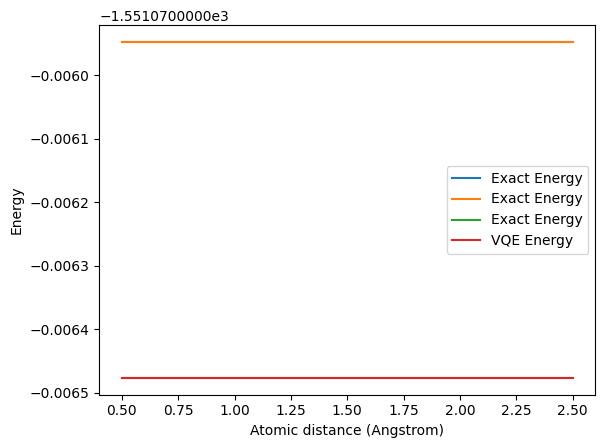

In [154]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [155]:
print(exact_energies)


[-1551.0764769759248, -1551.0764769759242, -1551.0764769759244]


In [156]:
print(vqe_energies)

[-1551.0764769516977, -1551.076476951713, -1551.0764769516936]
